In [1]:
import torch

### Load Analyzed Games

In [2]:
dataset = torch.load("../datasets/all_games_analyzed.pt")

In [3]:
# dataset is of the form [(white_analysis, black_analysis), (white_elo, black_elo)]
print(f"Number of games: {len(dataset)}")
print(f"Moves of first game: {len(dataset[0][0][0])}")
print(f"Input size: {len(dataset[0][0][0][0])}")

input_size = len(dataset[0][0][0][0])

Number of games: 2000
Moves of first game: 14
Input size: 771


### Define the Model

In [4]:
from lstm_network import initialize_model

In [5]:
# Switch to GPU if available for faster calculations
if torch.cuda.is_available():
    device = torch.device("cuda")          # Use CUDA device
    print('Using GPU:', torch.cuda.get_device_name(0))
    torch.cuda.empty_cache()
else:
    device = torch.device("cpu") 

Using GPU: NVIDIA GeForce MX230


In [6]:
hidden_size = 128
num_layers = 2
lstm_model, optimizer = initialize_model(input_size, hidden_size, num_layers, device)

### Modify the dataset for training

In [7]:
import random

total_games = len(dataset)
# Define maximum elo in the dataset for normalization
max_elo = 3000
# max_elo = max([max(game[1]) for game in dataset])

# Spilt into train and test data
test_games = int(total_games * 0.15)

random.shuffle(dataset)

# Also batch together black and white analysis for each game
x_train = [torch.stack(game[0]).to(device) for game in dataset[:-test_games]]
y_train = [torch.tensor(game[1]).float().reshape((2, 1)).to(device)/max_elo for game in dataset[:-test_games]]

x_test =  [torch.stack(game[0]).to(device) for game in dataset[-test_games:]]
y_test =  [torch.tensor(game[1]).float().reshape((2, 1)).to(device)/max_elo for game in dataset[-test_games:]]

### Train the model

In [8]:
from lstm_network import train_model

In [9]:
# MSE loss for single output prediction
loss_func = torch.nn.functional.mse_loss

loss_graph = train_model(lstm_model, optimizer, loss_func, (x_train, y_train), num_epochs=10)

Epoch: 1, Validation Loss: 0.0283097873554367
Epoch: 2, Validation Loss: 0.02455098419035066
Epoch: 3, Validation Loss: 0.025043821768880054
Epoch: 4, Validation Loss: 0.02240569847397851
Epoch: 5, Validation Loss: 0.021525530411382335
Epoch: 6, Validation Loss: 0.023937306344062867
Epoch: 7, Validation Loss: 0.026134245140618826
Epoch: 8, Validation Loss: 0.023526224277106936
Epoch: 9, Validation Loss: 0.024618618385084477
Epoch: 10, Validation Loss: 0.019014234282675554


Text(0, 0.5, 'Loss')

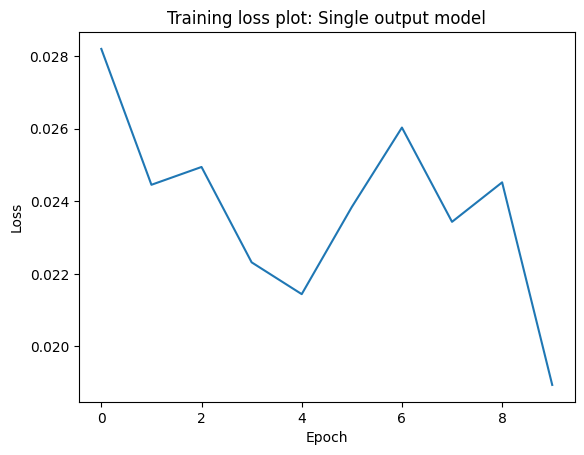

In [10]:
import matplotlib.pyplot as plt

# Visualize the loss as the network trained
# Should be a downward trend
plt.plot(loss_graph)
plt.title("Training loss plot: Single output model")
plt.xlabel("Epoch")
plt.ylabel("Loss")

### Test how the model predicts new data

The predictions of the model are compared to a random guessing and a constant guessing model

In [11]:
predictions = []
real_values = []

for x, y in zip(x_test, y_test):
    # Predict for white and black
    out = lstm_model(x[0], train=False)[0] # [0] to get rid of hidden states
    predictions.append(out[0].item() * max_elo)
    real_values.append(y[0].item() * max_elo)

    out = lstm_model(x[1], train=False)[0]
    
    predictions.append(out[0].item() * max_elo) # [0].item() to get rid of batch dimension and get the elo prediction
    real_values.append(y[1].item() * max_elo)

In [12]:
def rate_predictions(predictions, real_values):
    correct = 0
    diff = 0
    high_elo = [0, 0]
    low_elo = [0, 0]
    real_high = 0
    real_low = 0
    # We give the model a leeway of +-200 points
    # More leeway = more accuracy
    leeway = 200
    for prediction, real in zip(predictions, real_values):
        if real - leeway <= prediction <= real + leeway:
            correct += 1
        diff += abs(prediction - real)
        if real > 1700:
            high_elo[0] += 1
            high_elo[1] += prediction
            real_high += real
        if real <= 1700:
            low_elo[0] += 1
            low_elo[1] += prediction
            real_low += real
    return correct / len(predictions), correct, diff/len(predictions), high_elo[1]/high_elo[0], low_elo[1]/low_elo[0], real_high/high_elo[0], real_low/low_elo[0]

percentage, correct, diff, high_predictions, low_predictions, real_high, real_low = rate_predictions(predictions, real_values)
print(f"Correctly predicted {percentage * 100:.2f}% of games")
print(f"{correct} out of {len(predictions)} predictions")
print(f"Average difference: {diff:.2f} elo")
print(f"Average prediction for high elo games: {high_predictions:.2f} elo. Real average: {real_high:.2f} elo")
print(f"Average prediction for low elo games: {low_predictions:.2f} elo. Real average: {real_low:.2f} elo")

Correctly predicted 30.50% of games
183 out of 600 predictions
Average difference: 381.09 elo
Average prediction for high elo games: 1988.24 elo. Real average: 2227.96 elo
Average prediction for low elo games: 1584.25 elo. Real average: 1200.36 elo


In [13]:
import random

random_predictions = [random.randint(800, 3000) for _ in range(len(predictions))]
percentage, correct, diff, _, _, _, _ = rate_predictions(random_predictions, real_values)
print(f"Correctly guessed at random {percentage * 100:.2f}% of games")
print(f"{correct} out of {len(random_predictions)} predictions")  
print(f"Average difference: {diff:.2f} elo") 

Correctly guessed at random 16.83% of games
101 out of 600 predictions
Average difference: 701.53 elo


In [15]:
constant_predictions = [(800 + 2800)//2 for _ in range(len(predictions))]
percentage, correct, diff, _, _, _, _  = rate_predictions(constant_predictions, real_values)
print(f"Correctly guessed with constant guess {percentage * 100:.2f}% of games")
print(f"{correct} out of {len(constant_predictions)} predictions")
print(f"Average difference: {diff:.2f} elo")

Correctly guessed with constant guess 22.33% of games
134 out of 600 predictions
Average difference: 516.85 elo


In [28]:
# If the results are acceptable, save the model
torch.save(lstm_model.state_dict(), "lstm_model_single_output.pt")